In [1]:
# Load packages
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))
suppressMessages(library(openair))

suppressMessages(library(BBmisc))
suppressMessages(library(caret))

suppressMessages(library(segmented))

suppressMessages(library(plyr))

In [2]:
suppressMessages(library(repr))
options(repr.plot.width=25,#14,
        repr.plot.height=10,#24,
        #repr.plot.pointsize=50,
        repr.plot.family='serif',
        repr.plot.family.size=200
       )

In [3]:
# Working directory
setwd("~/Repositories/AirQualityCOVID")

# Lockdown dates

In [4]:
periods <- list(
    # lockdown
    lockdown = ymd("2020-03-14"),
    #end.lockdown = as.numeric(ymd_hms("2020-04-28 00:00:00")),

    # poslockdown
    fases = ymd("2020-04-28"),#2020-05-01"),
    normalidad = ymd("2020-06-21"),

    # New lockdown
    new.lockdown = ymd("2020-10-25")
)

## Load Data

In [5]:
load("data/data_AQ.rda")
load("data/meteorology.rda")

sites <- "es0118a"

aq <- data_AQ %>%
            filter(site == sites,
                   #variable == "no2"
                  ) %>%
            timeAverage(avg.time = "day", type=c("site", "variable"))
aq$date <- as_date(aq$date)

mto <- data_Mto[data_Mto$site == sites, ]

df.data <- merge(aq, mto,
              by = c("site", "date"), all.x=T) %>%
        drop_na() %>%
        select(-date_end, -process, -summary, -validity)

rm(data_AQ)
rm(data_Mto)

## Analysis

In [16]:
fit.model <- function(pll, data.df) {
    data.df <- data.df %>% 
                filter(variable == pll) %>% 
                select(-site, -variable) %>% 
                normalize(method = "range", 
                          range = c(0, 1), margin = 1) %>%
                drop_na()
    data.df$wk.yr <- week(data.df$date)
    
    train.df <-  which(data.df$date < ymd("2020-01-01"))
    test.df <- which(data.df$date > ymd("2020-01-01"))
    
    fit.th <- train(value ~., 
                    data=data.df[, -1], subset=train.df,
                    method="knn",
                    na.action=na.omit,
                    tuneGrid=data.frame(k=2:5),
                    allowParallel = TRUE
                   )

    y.th <- predict(fit.th, newdata = data.df[test.df,])
    
    data.frame("variable"=rep(pll, length(test.df)),
               "date"=data.df[test.df, "date"],
               "obs"=data.df[test.df, "value"],
               "pred"=y.th)
               
}

In [ ]:
model.fit <- do.call(rbind, lapply(levels(df.data$variable), fit.model, df.data))
model.fit$diff <- model.fit$obs - model.fit$pred

In [ ]:
ggplot(model.fit, aes(x=date)) +
    scale_color_manual(values=c("knn-model" = "red",
                                "obs" = "black")) +
    geom_line(aes(y = obs, color="obs")) +
    geom_line(aes(y = pred, color="knn-model")) +
    facet_wrap(~variable, ncol=1, scale="free")

## Using `segmented` package

In [9]:
segment.data <- function(pll, data.df, init.seg) {
    data.df <- data.df %>% filter(variable == pll)
    
    my.seg <- segmented(lm(diff ~ date, data=data.df), 
                      seg.Z = ~ date,
                      psi = init.seg
                     )

    if (is.null(nrow(my.seg$psi))) {
        return.df <- data.frame(variable=pll)
    } else {
        return.df <- cbind(data.frame(variable=pll),
                           my.seg$psi)
    }
    return.df
    
}


In [10]:
seg.df <- do.call(rbind.fill, 
                  lapply(levels(as.factor(model.fit$variable)), 
                         segment.data, model.fit, unlist(periods))) %>% drop_na()

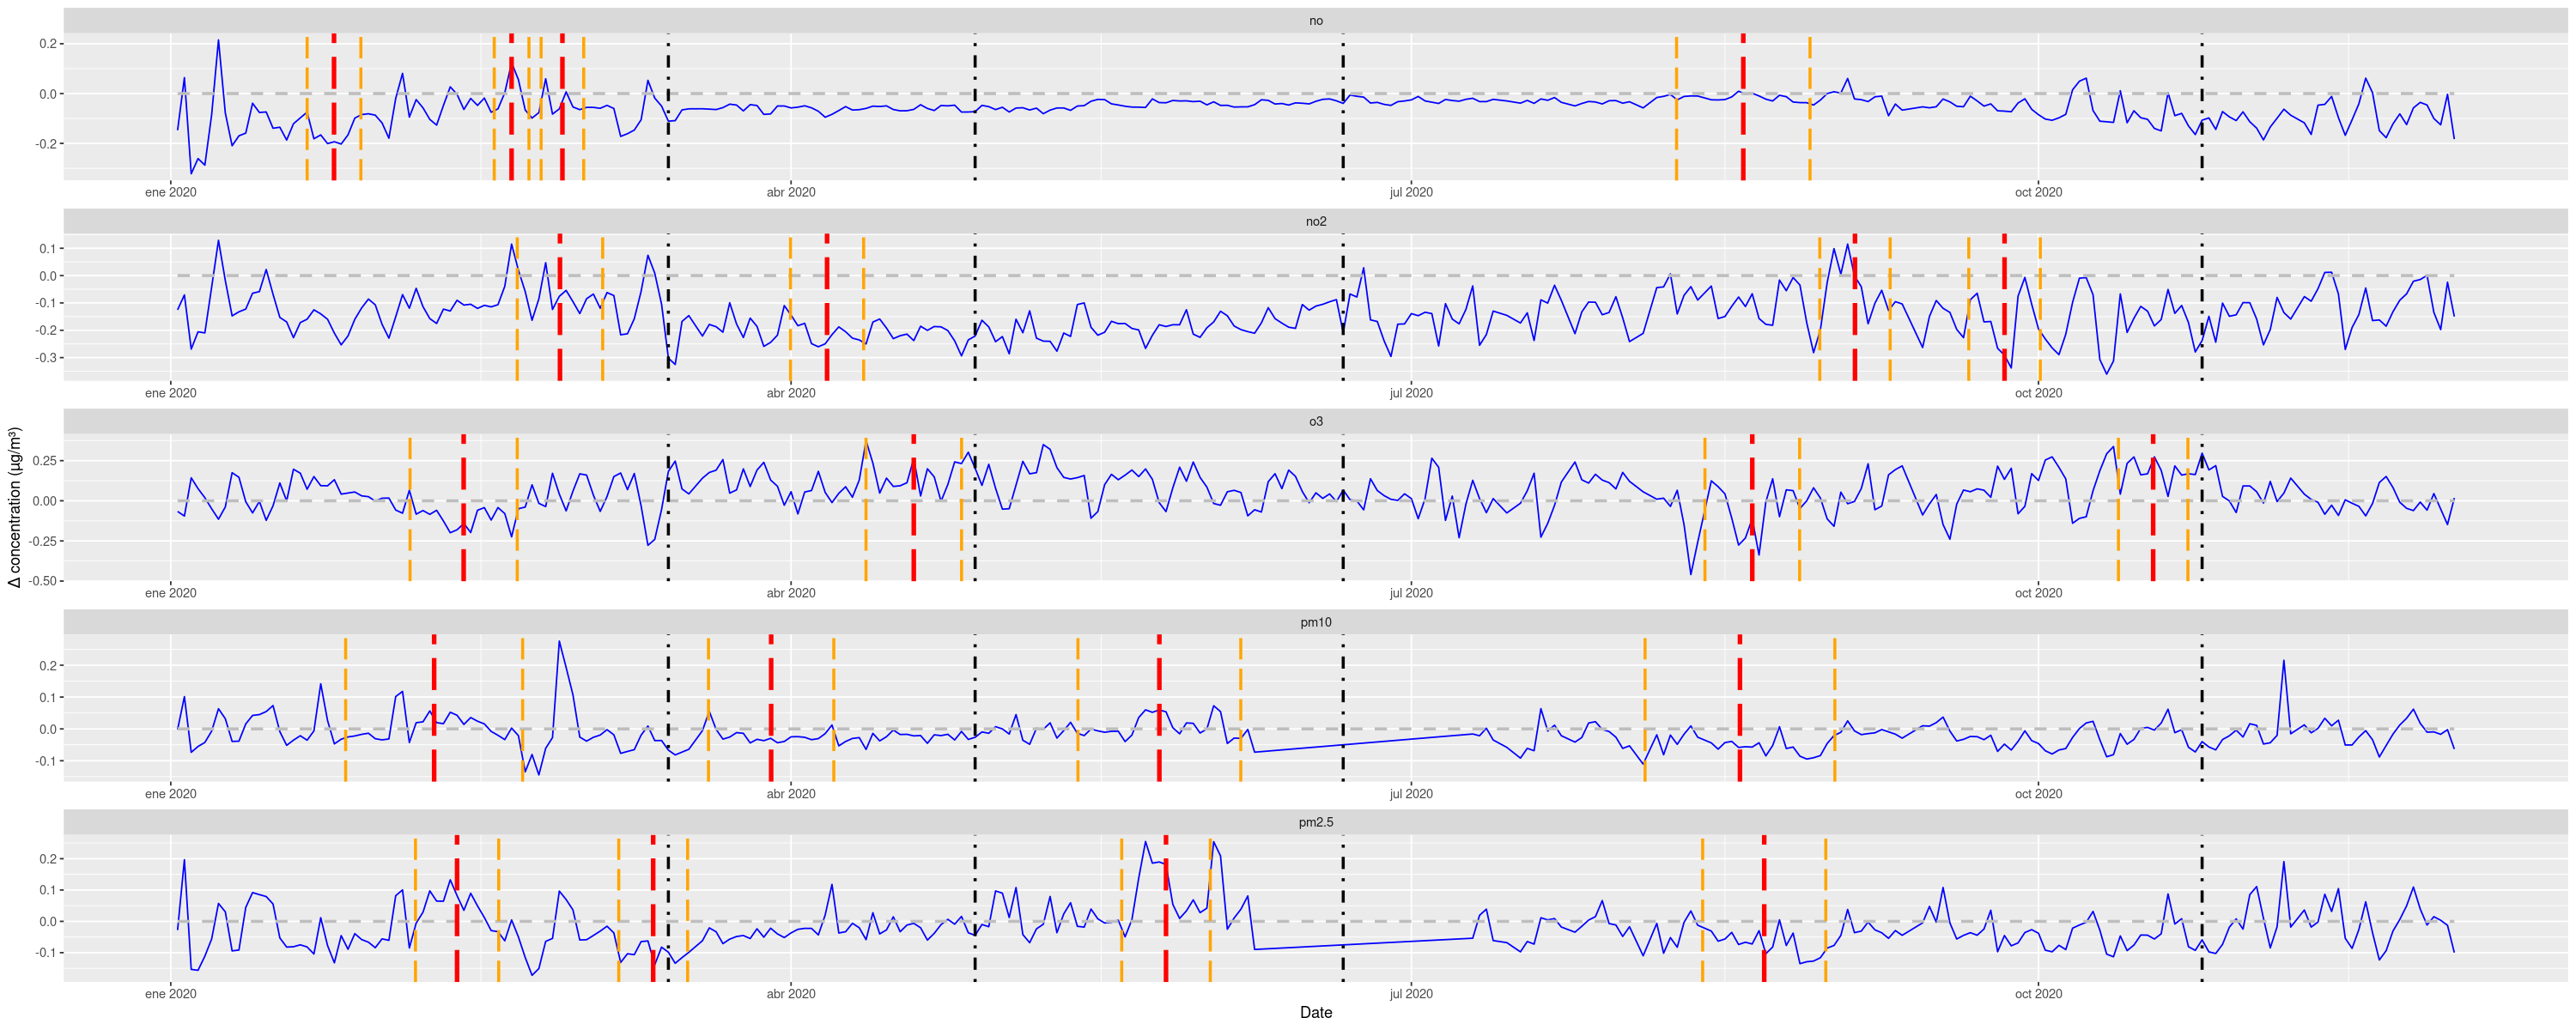

In [11]:
plot <- ggplot(data=model.fit, aes(x=as_date(date)))+ 
    geom_line(aes(y=diff), color="blue", size=0.5) +
    geom_line(aes(y=0), color="gray", linetype=2, size=1) +
    xlab("Date") + ylab("\u0394 concentration (\u00b5g/m\u00b3)") +
    facet_wrap(~variable, ncol=1, scale="free")

plot <- plot +
    geom_vline(data=seg.df, aes(xintercept = Est.), 
               linetype=5, color = "red", size=1.5) +
    geom_vline(data=seg.df, aes(xintercept = Est.+St.Err), 
               linetype=5, color = "orange", size=1) +
    geom_vline(data=seg.df, aes(xintercept = Est.-St.Err), 
               linetype=5, color = "orange", size=1)

for (k in 1:(length(periods))) {
    plot <- plot + geom_vline(xintercept = as.numeric(periods[k]), 
                              linetype=4, color = "black", size=1)
}

plot

```R
for (i in 1:nrow(seg.df)) {
print(paste(as_date(seg.df[i, "Initial"]), 
            as_date(seg.df[i, "Est."]), sep=" =>"))
}
```

In [12]:
fit.segment <- function(subset, df) {
    modl <- lm(diff ~ date, data=df[subset, ])
    
    fit.subset <- modl$coefficients[1] + modl$coefficients[2]*as.numeric(df[subset, "date"])
    
    list(modl$coefficients[2],
         data.frame(date = as_date(df[subset, "date"]),
                    obs=df[subset, "diff"],
                    fit= fit.subset
                   ))
}

In [13]:
pll.segment <- function(pll, df) {
    df.pll <- df %>% filter(variable == pll)
    
    dates <- c(as.numeric(min(df.pll$date)), 
               seg.df[seg.df$variable == pll, "Est."], 
               as.numeric(max(df.pll$date)))

    coeff <- c()
    data.fit <- data.frame()

    for (i in 2:length(dates)) {
        samp <- which(df.pll$date < dates[i] &
                      df.pll$date >= dates[i-1])

        result <- fit.segment(samp, df.pll)

        coeff <- c(coeff, result[1])
        data.fit <- rbind(data.fit, cbind(data.frame(i=as.factor(i-1)), result[2]))
    }
    
    cbind(data.frame(variable=rep(pll, nrow(data.fit))),
          data.fit)
}

In [14]:
data.fit <- do.call(rbind, lapply(levels(as.factor(model.fit$variable)), 
                                  pll.segment, model.fit))

head(data.fit)

,variable,i,date,obs,fit
,<chr>,<fct>,<date>,<dbl>,<dbl>
1,no,1,2020-01-02,-0.14721509,-0.1189397
2,no,1,2020-01-03,0.06388832,-0.1197077
3,no,1,2020-01-04,-0.32195579,-0.1204756
4,no,1,2020-01-05,-0.26097193,-0.1212435
5,no,1,2020-01-06,-0.28732393,-0.1220115
6,no,1,2020-01-07,-0.08450147,-0.1227794


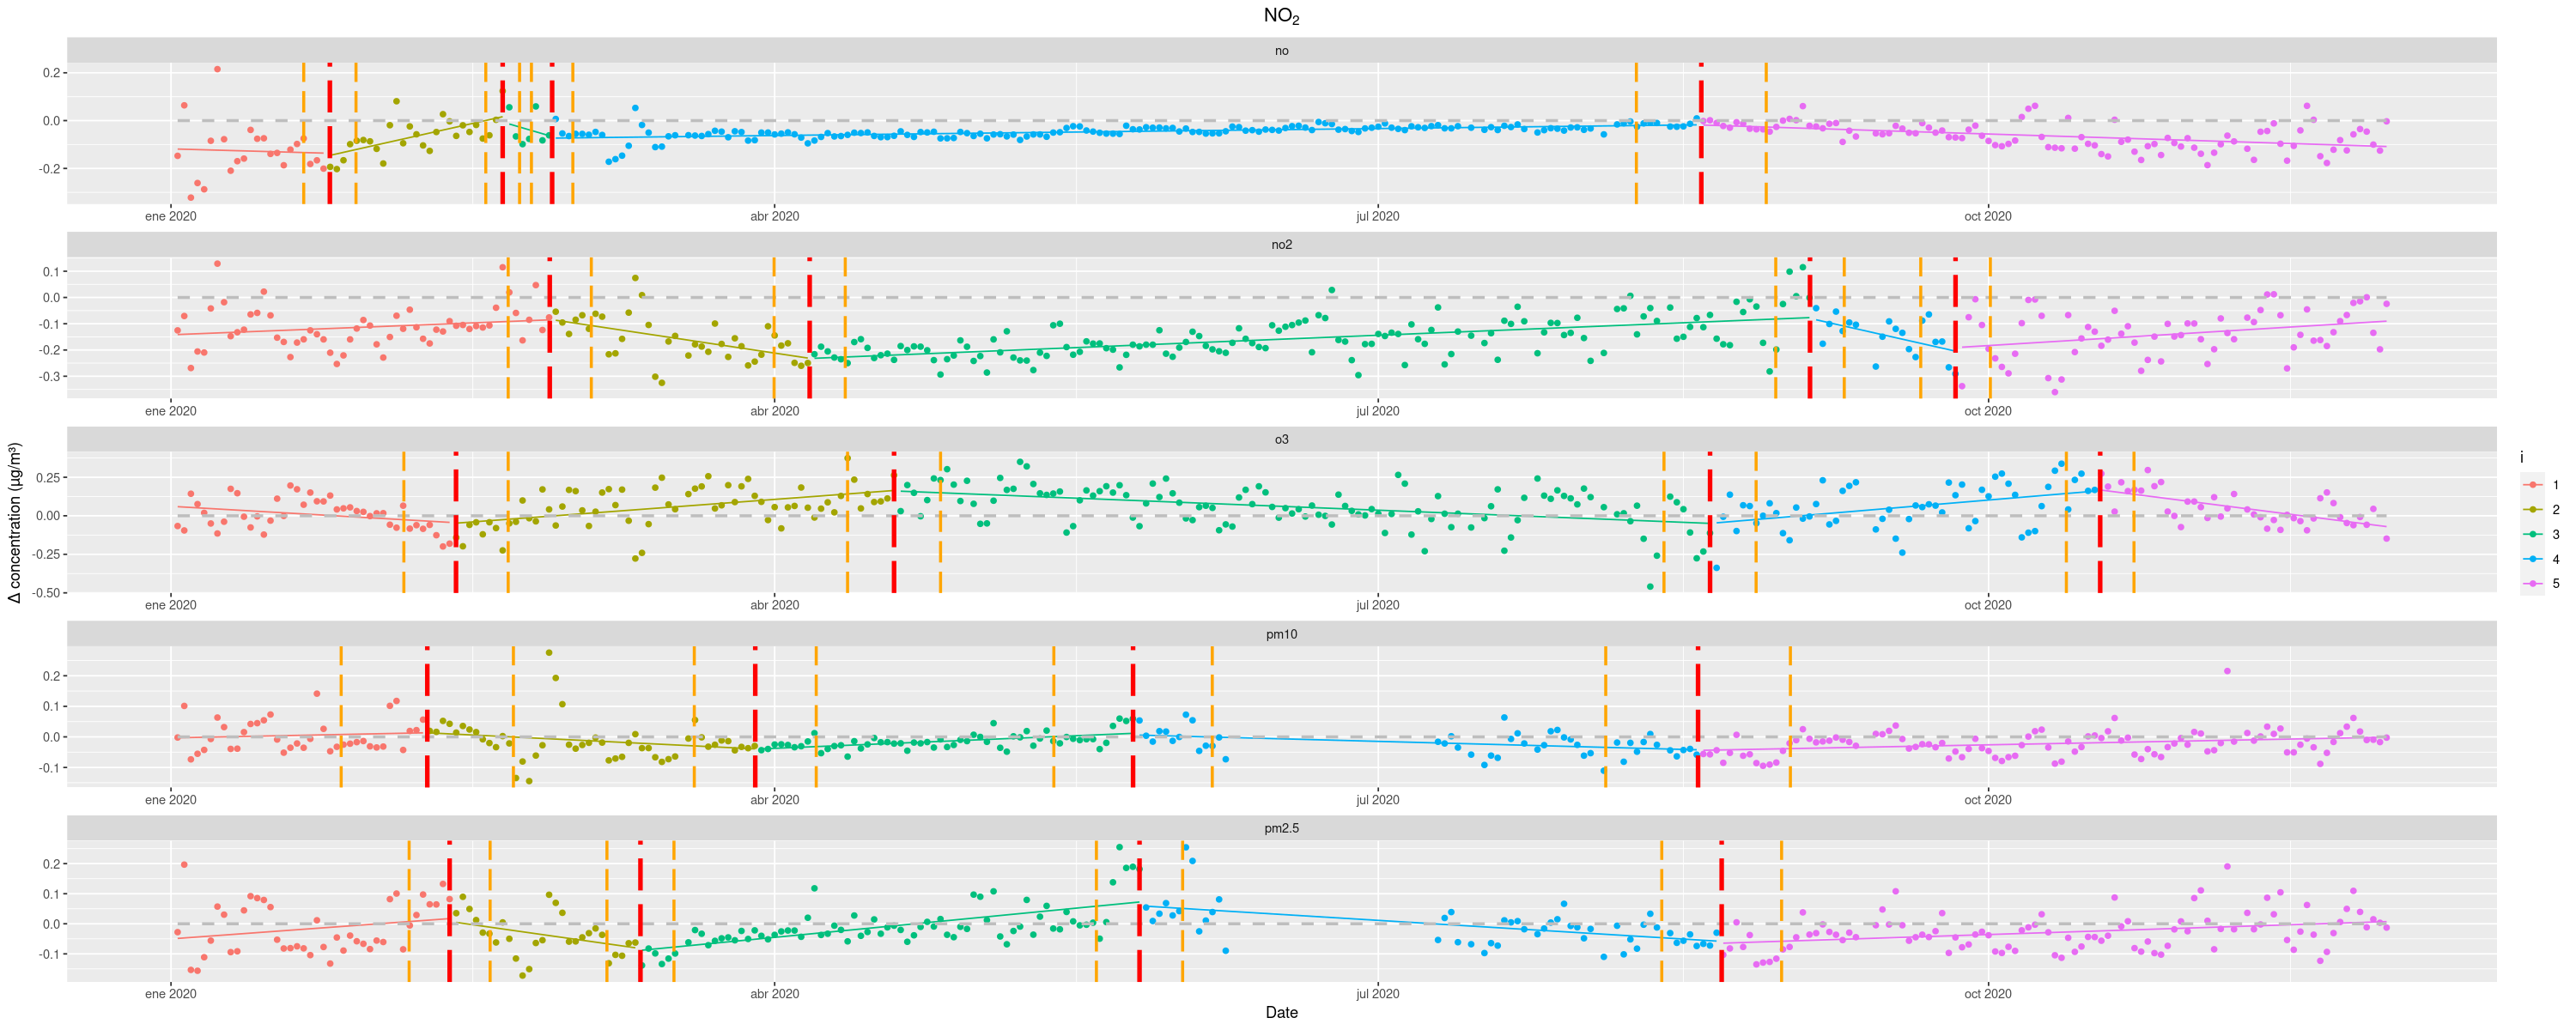

In [15]:
plot <- ggplot(data.fit, aes(x=as_date(date))) +
    geom_point(aes(y=obs, color=i)) +
    geom_line(aes(y=fit, color=i)) +
    geom_line(aes(y=0), color="gray", linetype=2, size=1) +
    labs(title=expression(paste("NO"[2])),
         x=expression("Date"), 
         y =expression("\u0394 concentration (\u00b5g/m\u00b3)")) +
    theme(plot.title = element_text(hjust = 0.5)) +
    facet_wrap(~variable, ncol=1, scale="free")
    
plot <- plot +
    geom_vline(data=seg.df, aes(xintercept = Est.), 
               linetype=5, color = "red", size=1.5) +
    geom_vline(data=seg.df, aes(xintercept = Est.+St.Err), 
               linetype=5, color = "orange", size=1) +
    geom_vline(data=seg.df, aes(xintercept = Est.-St.Err), 
               linetype=5, color = "orange", size=1)

plot